In [109]:
from pathlib import Path
from typing import Iterable, Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="white")

ROGI_KEY = "rogi"
CSV_DIR = Path("./results/raw/dockstring")

In [110]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]

    vals = set(vals)
    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()

    for line in gridlines:
        val = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if val in vals:
            line.set_visible(False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

In [111]:
dfs = list(map(pd.read_csv, CSV_DIR.iterdir()))
df = pd.concat(dfs, ignore_index=True)\
    .groupby(["featurizer", "dataset_and_task"]).agg(["mean", "std", "count"])\
    .sort_index()
    # .set_index(['featurizer', 'dataset_and_task'])\
    # .sort_index()

df.head(15)

n_valid                 rogi                
                                  mean  std count      mean       std count
featurizer dataset_and_task                                                
chemberta  DOCKSTRING/ABL1     10000.0  0.0     5  0.213638  0.007918     5
           DOCKSTRING/ACHE     10000.0  0.0     5  0.210951  0.014437     5
           DOCKSTRING/ADAM17   10000.0  0.0     5  0.226637  0.007501     5
           DOCKSTRING/ADORA2A  10000.0  0.0     5  0.205813  0.009658     5
           DOCKSTRING/ADRB1    10000.0  0.0     5  0.159486  0.037104     5
           DOCKSTRING/ADRB2    10000.0  0.0     5  0.116579  0.040614     5
           DOCKSTRING/AKT1     10000.0  0.0     5  0.142189  0.023245     5
           DOCKSTRING/AKT2     10000.0  0.0     5  0.209965  0.017070     5
           DOCKSTRING/AR       10000.0  0.0     5  0.062354  0.013847     5
           DOCKSTRING/BACE1    10000.0  0.0     5  0.218182  0.017782     5
           DOCKSTRING/CA2      10000.0  0.0     5  0.202097  0.008603     5
           DOCKSTRING/CASP3    10000.0  0.0     5  0.214048  0.022597     5
           DOCKSTRING/CDK2     10000.0  0.0     5  0.204129  0.011702     5
           DOCKSTRING/CSF1R    10000.0  0.0     5  0.205381  0.010169     5
           DOCKSTRING/CYP2C9   10000.0  0.0     5  0.195323  0.058652     5

In [108]:
df.groupby(["featurizer", "dataset_and_task"]).agg(["mean", "std", "count"])

n_valid                 rogi           
                                       mean  std count      mean  std count
featurizer dataset_and_task                                                
chemberta  AMLODIPINE_MPO           10000.0  0.0     5  0.375792  0.0     5
           ARIPIPRAZOLE_SIMILARITY  10000.0  0.0     5  0.224105  0.0     5
           CACO2_WANG                 910.0  0.0     5  0.286850  0.0     5
           CELECOXIB_REDISCOVERY    10000.0  0.0     5  0.244493  0.0     5
           CLEARANCE_HEPATOCYTE_AZ   1213.0  0.0     5  0.569957  0.0     5
...                                     ...  ...   ...       ...  ...   ...
vae        SCAFFOLD HOP             10000.0  0.0     5  0.249315  0.0     5
           SOLUBILITY_AQSOLDB        9982.0  0.0     5  0.242705  0.0     5
           VALSARTAN_SMARTS         10000.0  0.0     5  0.016106  0.0     5
           VDSS_LOMBARDO             1130.0  0.0     5  0.050317  0.0     5
           ZALEPLON_MPO             10000.0  0.0     5  0.334580  0.0     5

[130 rows x 6 columns]

In [105]:
from scipy import stats

df_ = df.groupby(["featurizer", "dataset_and_task"]).agg(["mean", "std", "count"])
A = df_.loc['vae']["rogi"].values
B = df_.loc['vae']['rogi'].values

stats.ttest_ind(A[:, 0], B[:, 0], alternative="less")
# stats.ttest_ind_from_stats(
#     A[:, 0], A[:, 1], A[:, 2],
#     B[:, 0], B[:, 1], B[:, 2],
#     alternative="less"
# )

Ttest_indResult(statistic=0.0, pvalue=0.5)

In [93]:
a = stats.norm.rvs(loc=0, scale=1, size=500)
b = stats.norm.rvs(loc=5, scale=10, size=500)

stats.ttest_ind(a, b, alternative="less")

Ttest_indResult(statistic=-8.320077294994244, pvalue=1.4317051105645692e-16)

In [77]:
def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    BUFFER = 0.03

    x = df.xs(x_key.lower(), level=1)[ROGI_KEY]['mean'].values
    y = df.xs(y_key.lower(), level=1)[ROGI_KEY]['mean'].values
    s = df.xs(x_key.lower(), level=1)["n_valid"]['mean'].values / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)

    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    # val = f"{rogi_string(y_key)} > {rogi_string(x_key)}"
    N = (z > threshold).sum()
    s = rf"$\Delta_\% \geq {threshold}$ : {N}/{len(z)}"
    ax.text(
        0 + BUFFER, 1 - BUFFER, s, fontsize=12,
        transform=ax.transAxes, ha="left", va="top"
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(axis="both", ls="--")

    ax.set_ylabel(rogi_string(y_key))

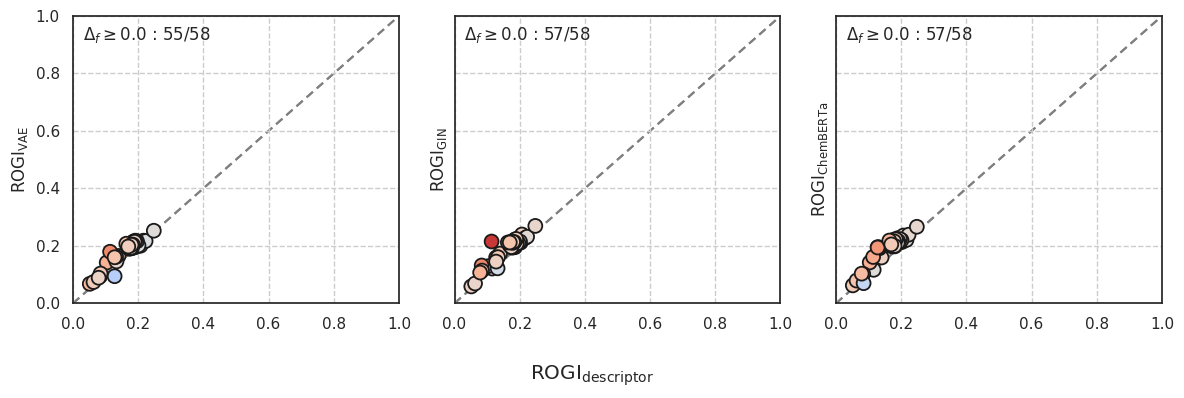

In [79]:
X_KEY = "descriptor"
Y_KEYS = ["VAE", "GIN", "ChemBERTa"]
N = len(Y_KEYS)

fig, axs = plt.subplots(1, N, figsize=(4 * N, 4), sharex=True, sharey=True)

for ax, y_key in zip(axs, Y_KEYS):
    parity_plot(ax, df, X_KEY, y_key, 0.)

fig.supxlabel(rogi_string(X_KEY))
fig.tight_layout()

In [4]:
fig.savefig("./results/figures/vae-gin-bert-gpt.pdf", bbox_inches="tight")

In [6]:
def boxplot(ax: plt.Axes, df, x_key, y_keys, threshold: float = 0.1):
    LINE_WIDTH = 1.5
    BUFFER = 0.02

    x = df.xs(x_key, level=1)[ROGI_KEY]['mean'].values
    ys = [df.xs(k.lower(), level=1)[ROGI_KEY]['mean'].values for k in y_keys]
    Z = np.array(ys) / x - 1
    
    props = dict(
        boxprops=dict(fc="b", lw=LINE_WIDTH),
        whiskerprops=dict(lw=LINE_WIDTH),
        capprops=dict(lw=LINE_WIDTH),
        meanprops=dict(marker='^', mfc='w', mec='k'),
        medianprops=dict(ls='--', c='w'),
    )

    _ = ax.boxplot(
        Z.T,
        vert=False,
        labels=y_keys,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        **props
    )

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))
    ax.axvline(0, ls="--", color="r", dashes=(5, 4))

    for j, z in enumerate(Z):
        s = rf"$f\geq{threshold}$ = {(z > threshold).sum()}/{len(z)}"
        ax.text(
            1 + BUFFER, j+1, s, fontsize=10,
            ha="right", va="center"
        )

    ax.set_xlabel(f"Fractional difference betweeen {rogi_string('*')} and {rogi_string('desc')}")

    return ax

<AxesSubplot: xlabel='Fractional difference betweeen $\\mathrm{ROGI}_{\\mathrm{*}}$ and $\\mathrm{ROGI}_{\\mathrm{desc}}$'>

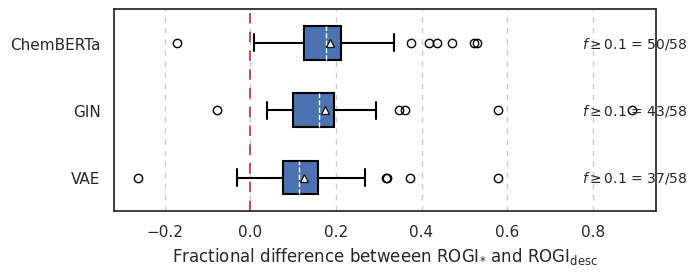

In [82]:
sns.set_palette("deep", color_codes=True)

Y_KEYS = ["VAE", "GIN", "ChemBERTa"]
fig, ax = plt.subplots(1, 1, figsize=(7, len(Y_KEYS) * 0.875))
boxplot(ax, df, "descriptor", Y_KEYS, 0.1)

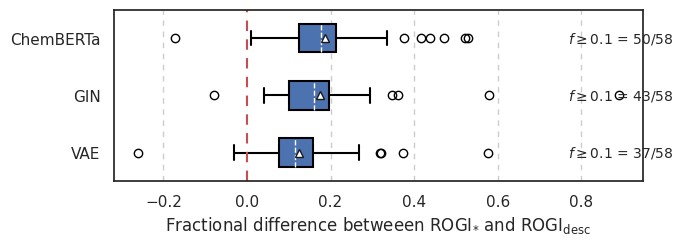

In [83]:
disable_gridlines(ax, "x", [0])
fig.tight_layout()
fig

In [10]:
fig.savefig("./results/figures/boxplot.pdf", bbox_inches="tight")